In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from astropy.time import Time

import sys
sys.path.insert(0, '../')

In [2]:
from libra import ObservationArchive, mask_simultaneous_transits, transit_model, trappist1

In [3]:
def model(params, planet, times):
    original_params = trappist1(planet)
    amp, depth, t0, c0, c1 = params
    original_params.rp = depth**0.5
    original_params.t0 = t0
    
    t = times - times.mean()
    
    fluxes = (amp * transit_model(times, original_params) + 
              c0 * t +  c1 * t**2)
    
    return fluxes

def chi2(params, planet, times, observed_fluxes, obs_err):
    model_fluxes = model(params, planet, times)
    return np.sum( (observed_fluxes - model_fluxes)**2 / obs_err**2)


from celerite.modeling import Model
from copy import deepcopy
from celerite import terms
import celerite
from scipy.optimize import minimize
original_params = trappist1('b')

class MeanModel(Model):
    parameter_names = ['amp', 'depth', 't0']

    def get_value(self, t):
        params = deepcopy(original_params)
        params.rp = self.depth**0.5
        params.t0 = self.t0
        times = t - t.mean()
        return self.amp * transit_model(t, params)

In [4]:
from scipy.optimize import fmin_l_bfgs_b

In [5]:
# import h5py
# f = h5py.File('/Users/bmmorris/git/libra/libra/data/outputs/trappist1_bright.hdf5')

# dict(f['h']['2018-11-09T12:58:39.195'].attrs)

In [6]:
from libra import nirspec_pixel_wavelengths

wavelengths = nirspec_pixel_wavelengths()

n_bins = 5
bin_width = len(wavelengths) // n_bins
bin_width
bin_centers = np.array([wavelengths[i*bin_width:(i+1)*bin_width].mean().value 
                        for i in range(n_bins)])

In [7]:
bin_centers

array([ 0.95934828,  2.29941717,  3.42829475,  4.27133223,  4.9657523 ])

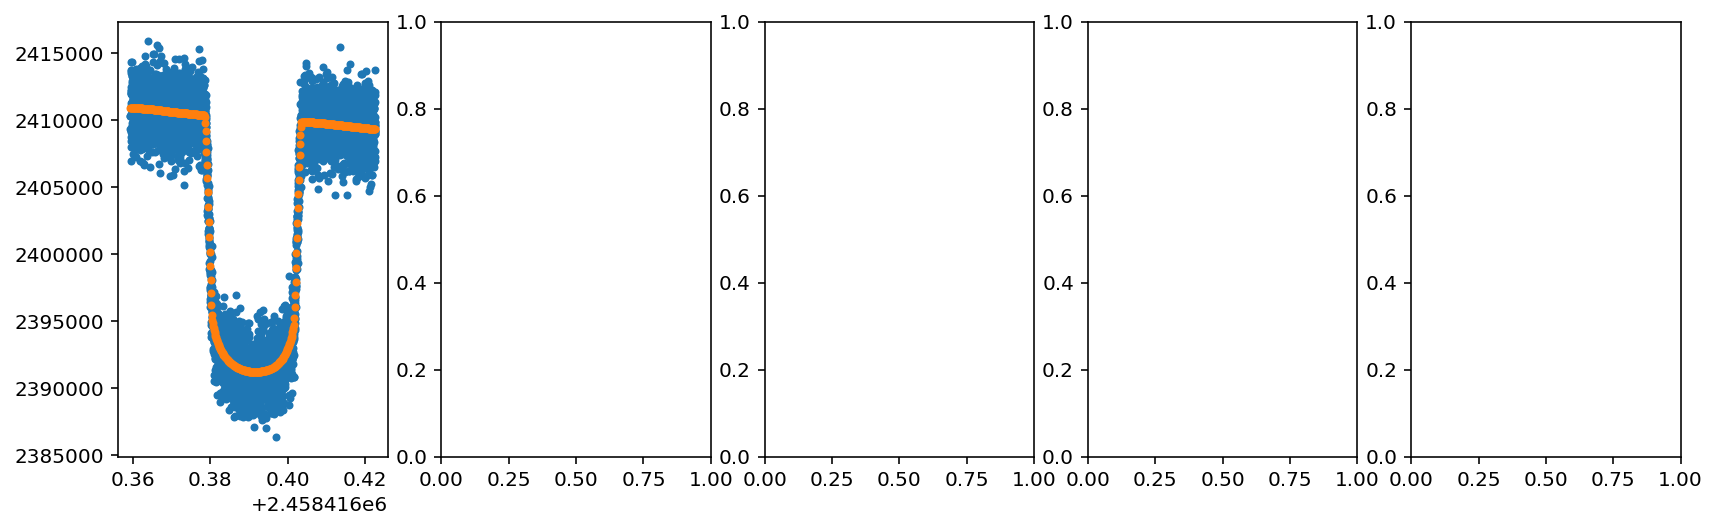

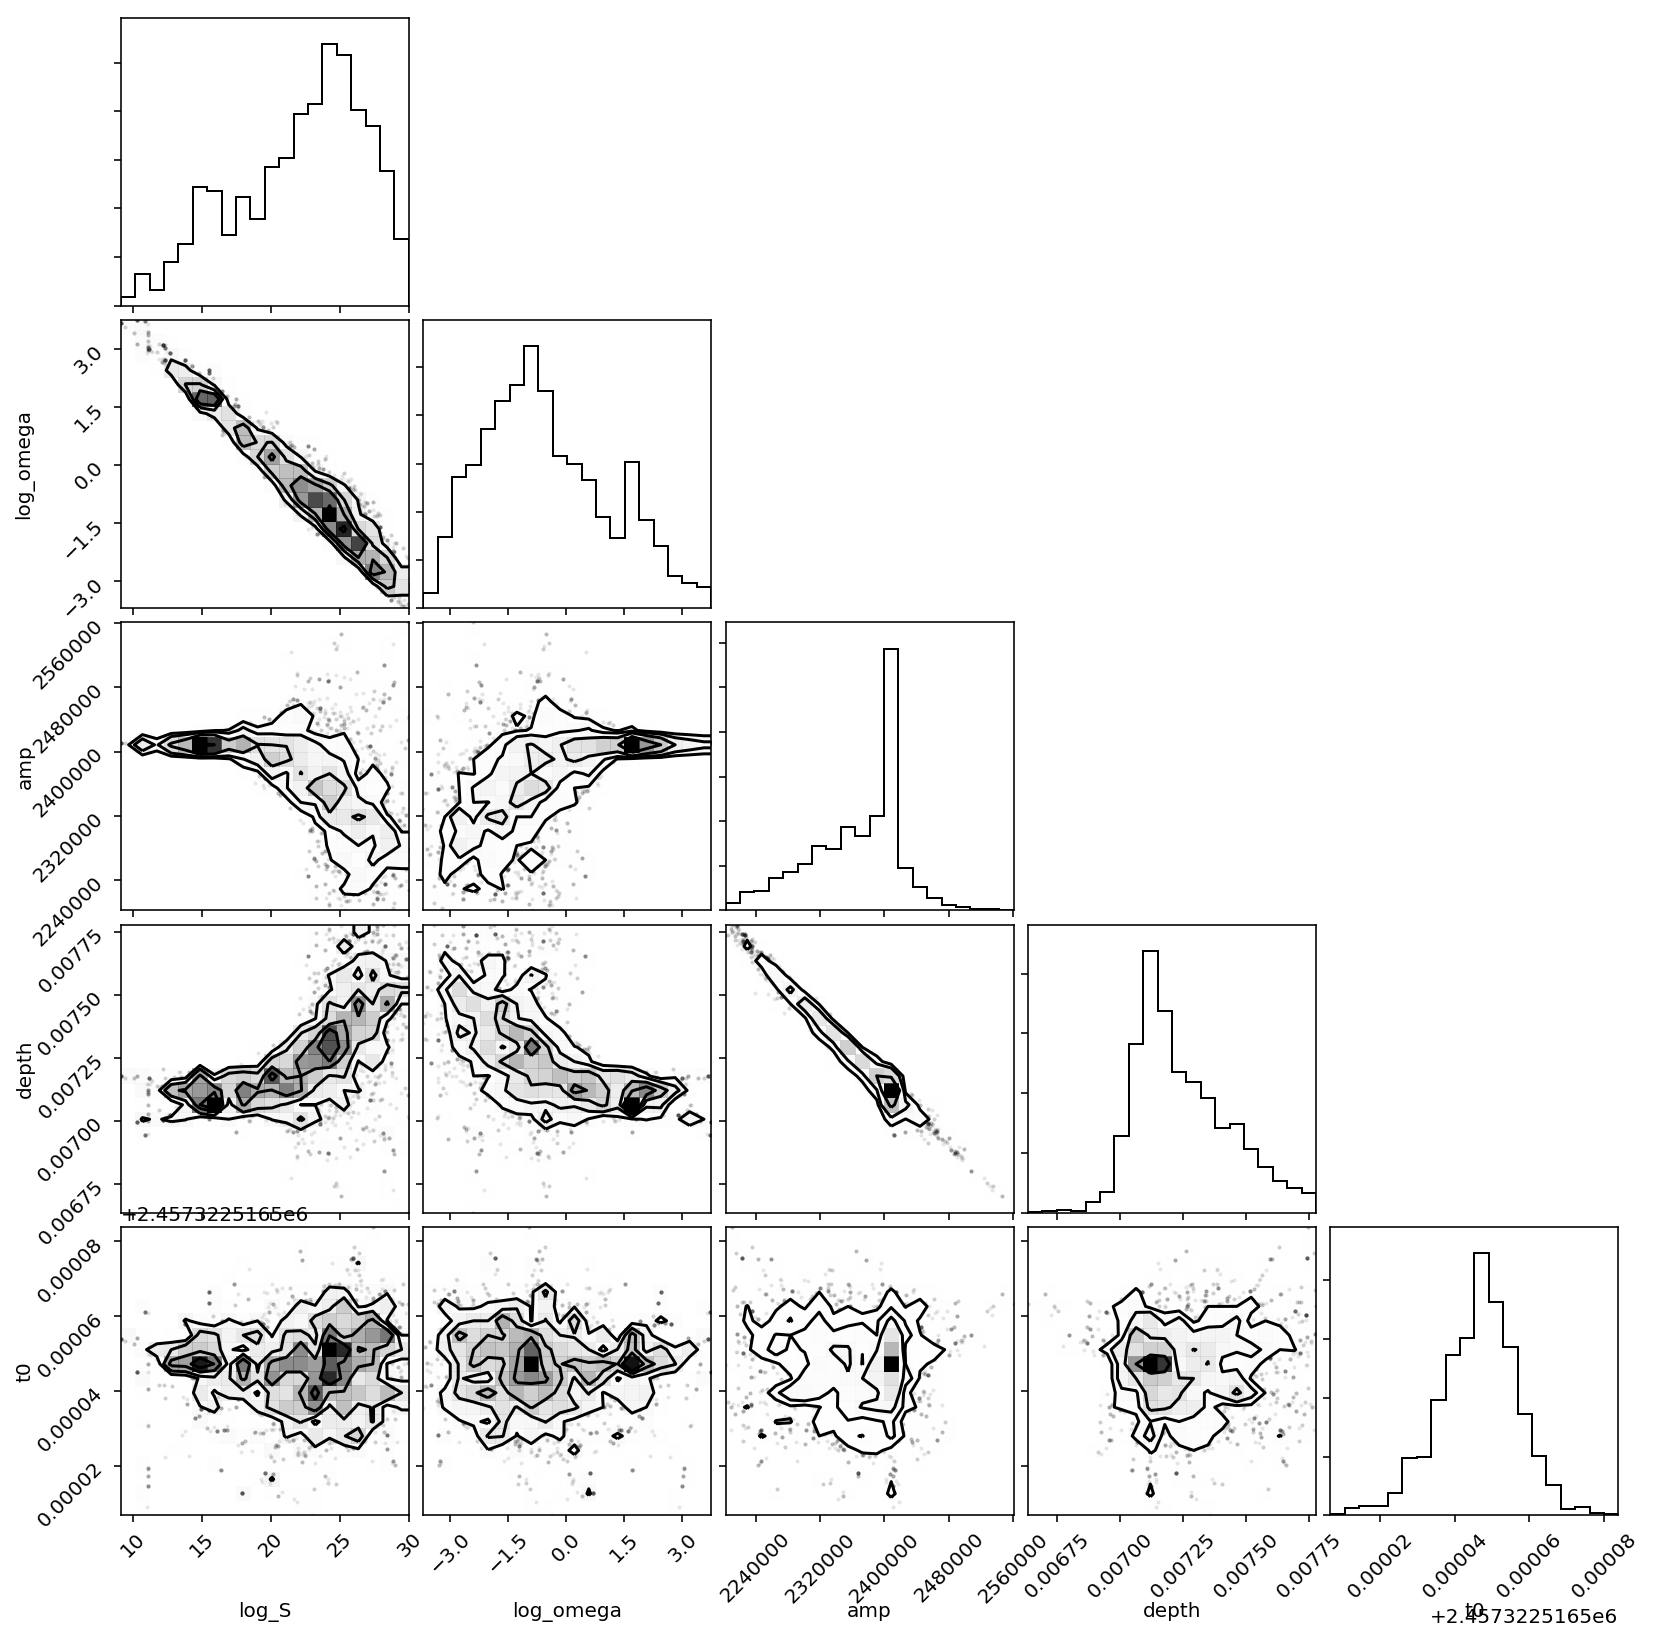

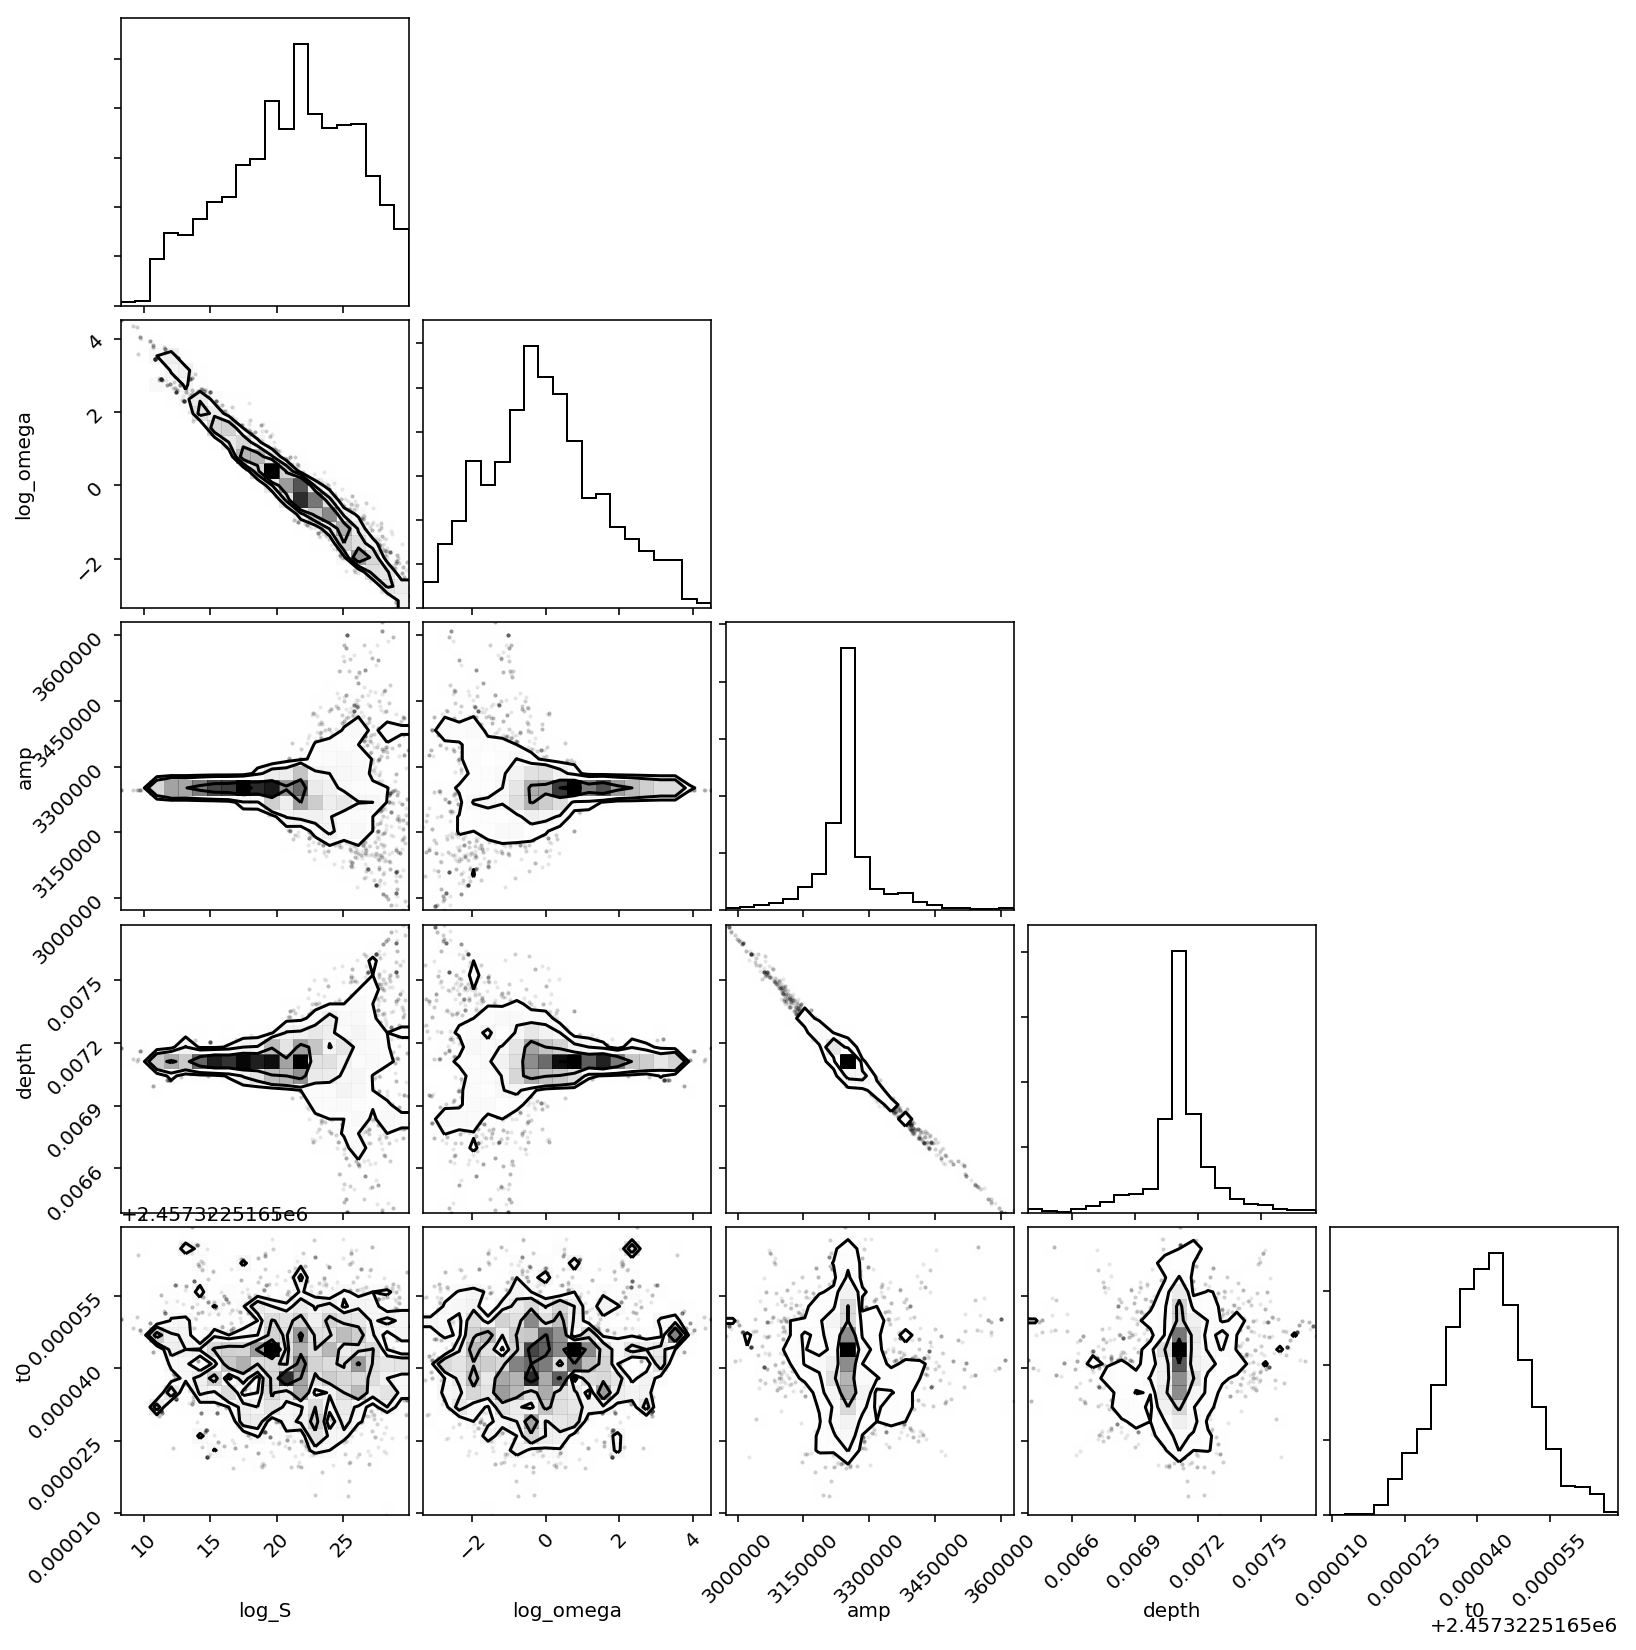

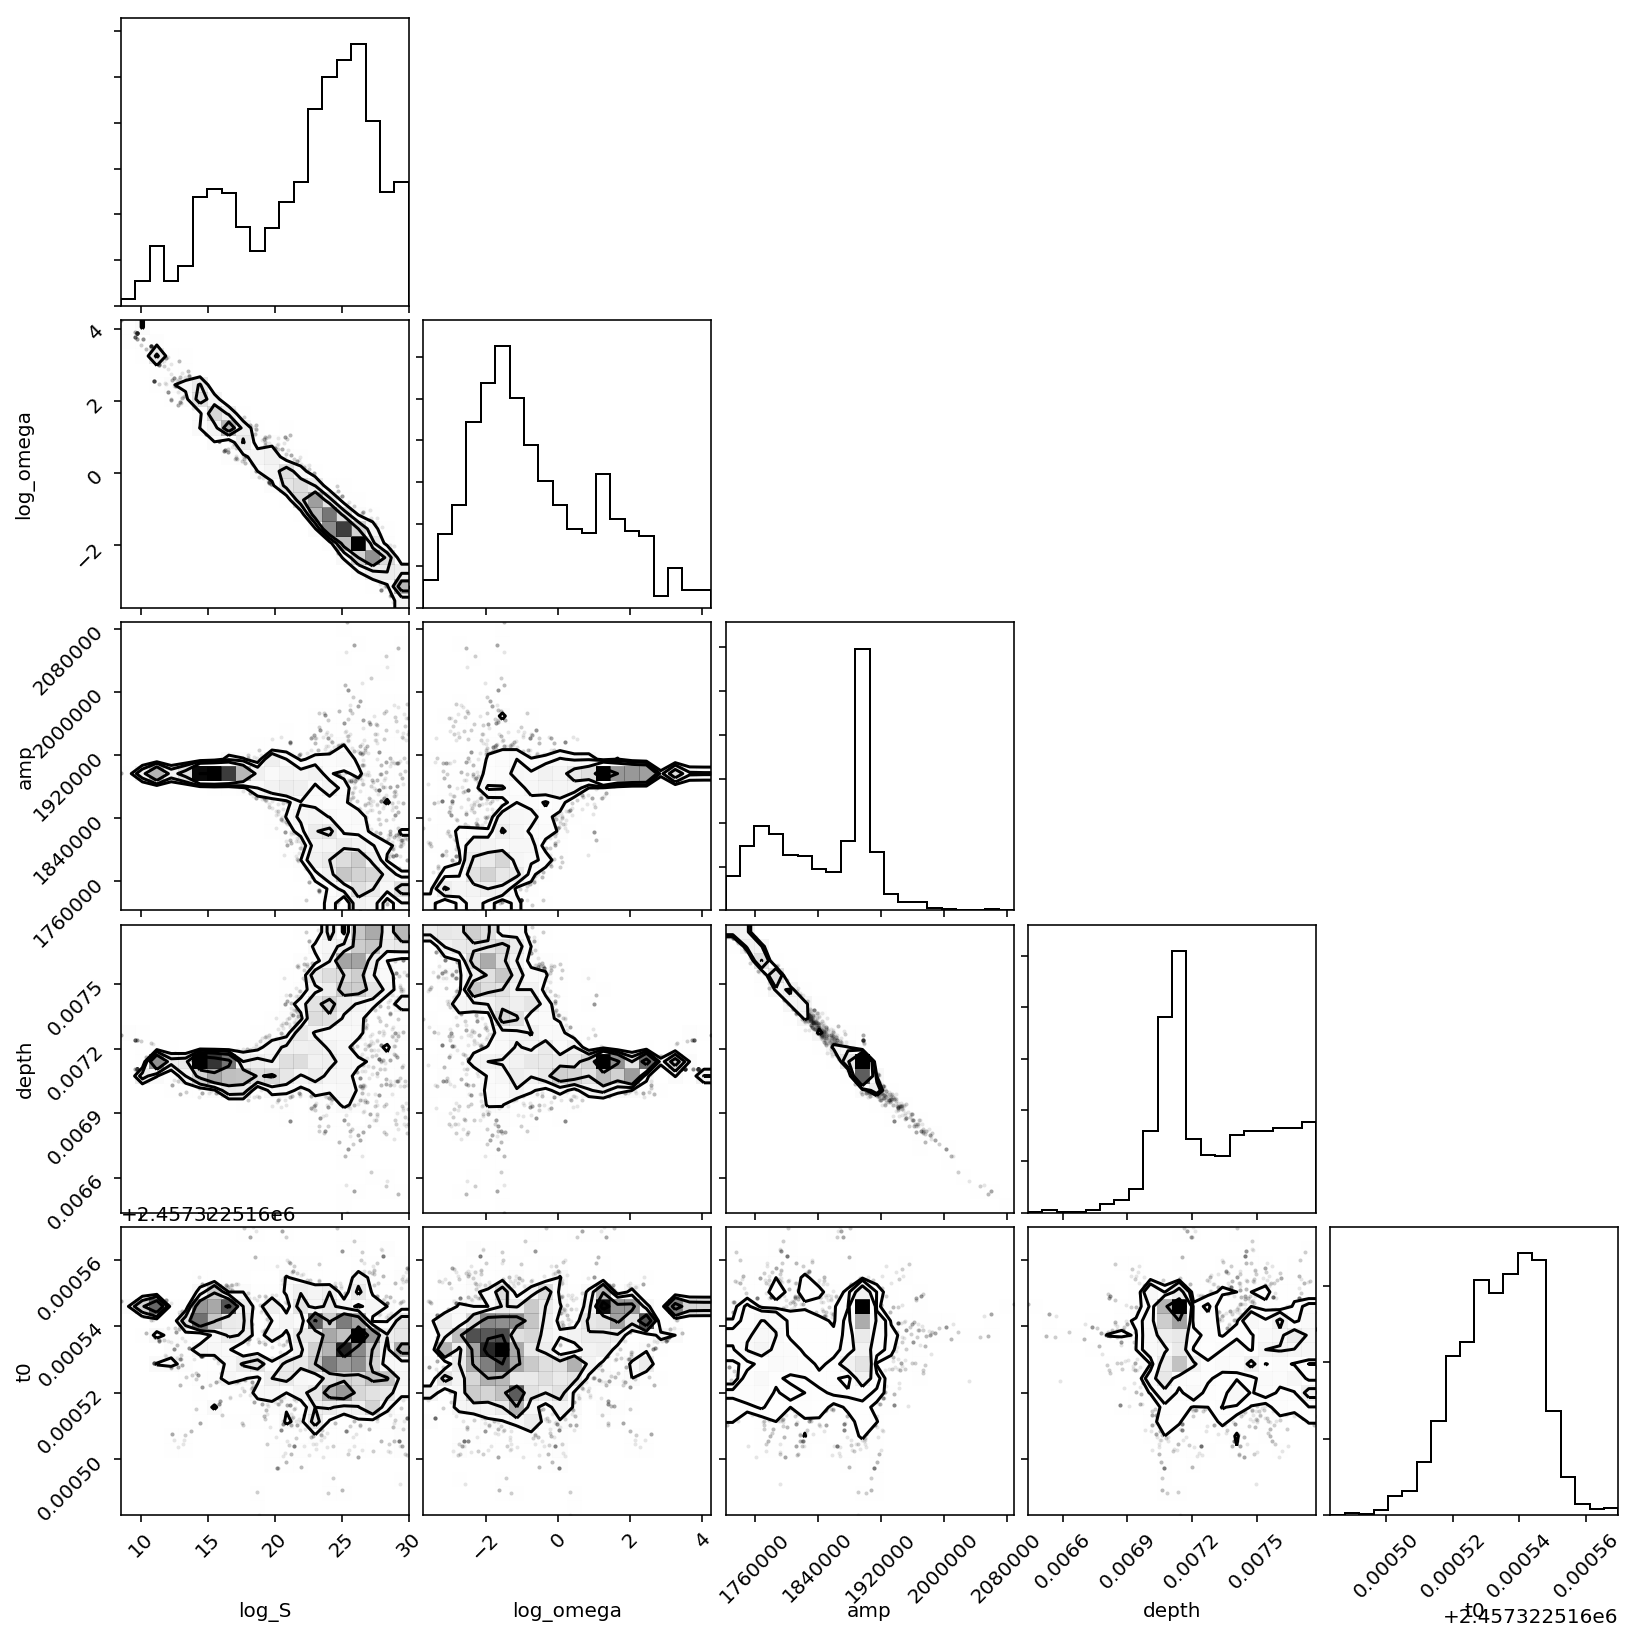

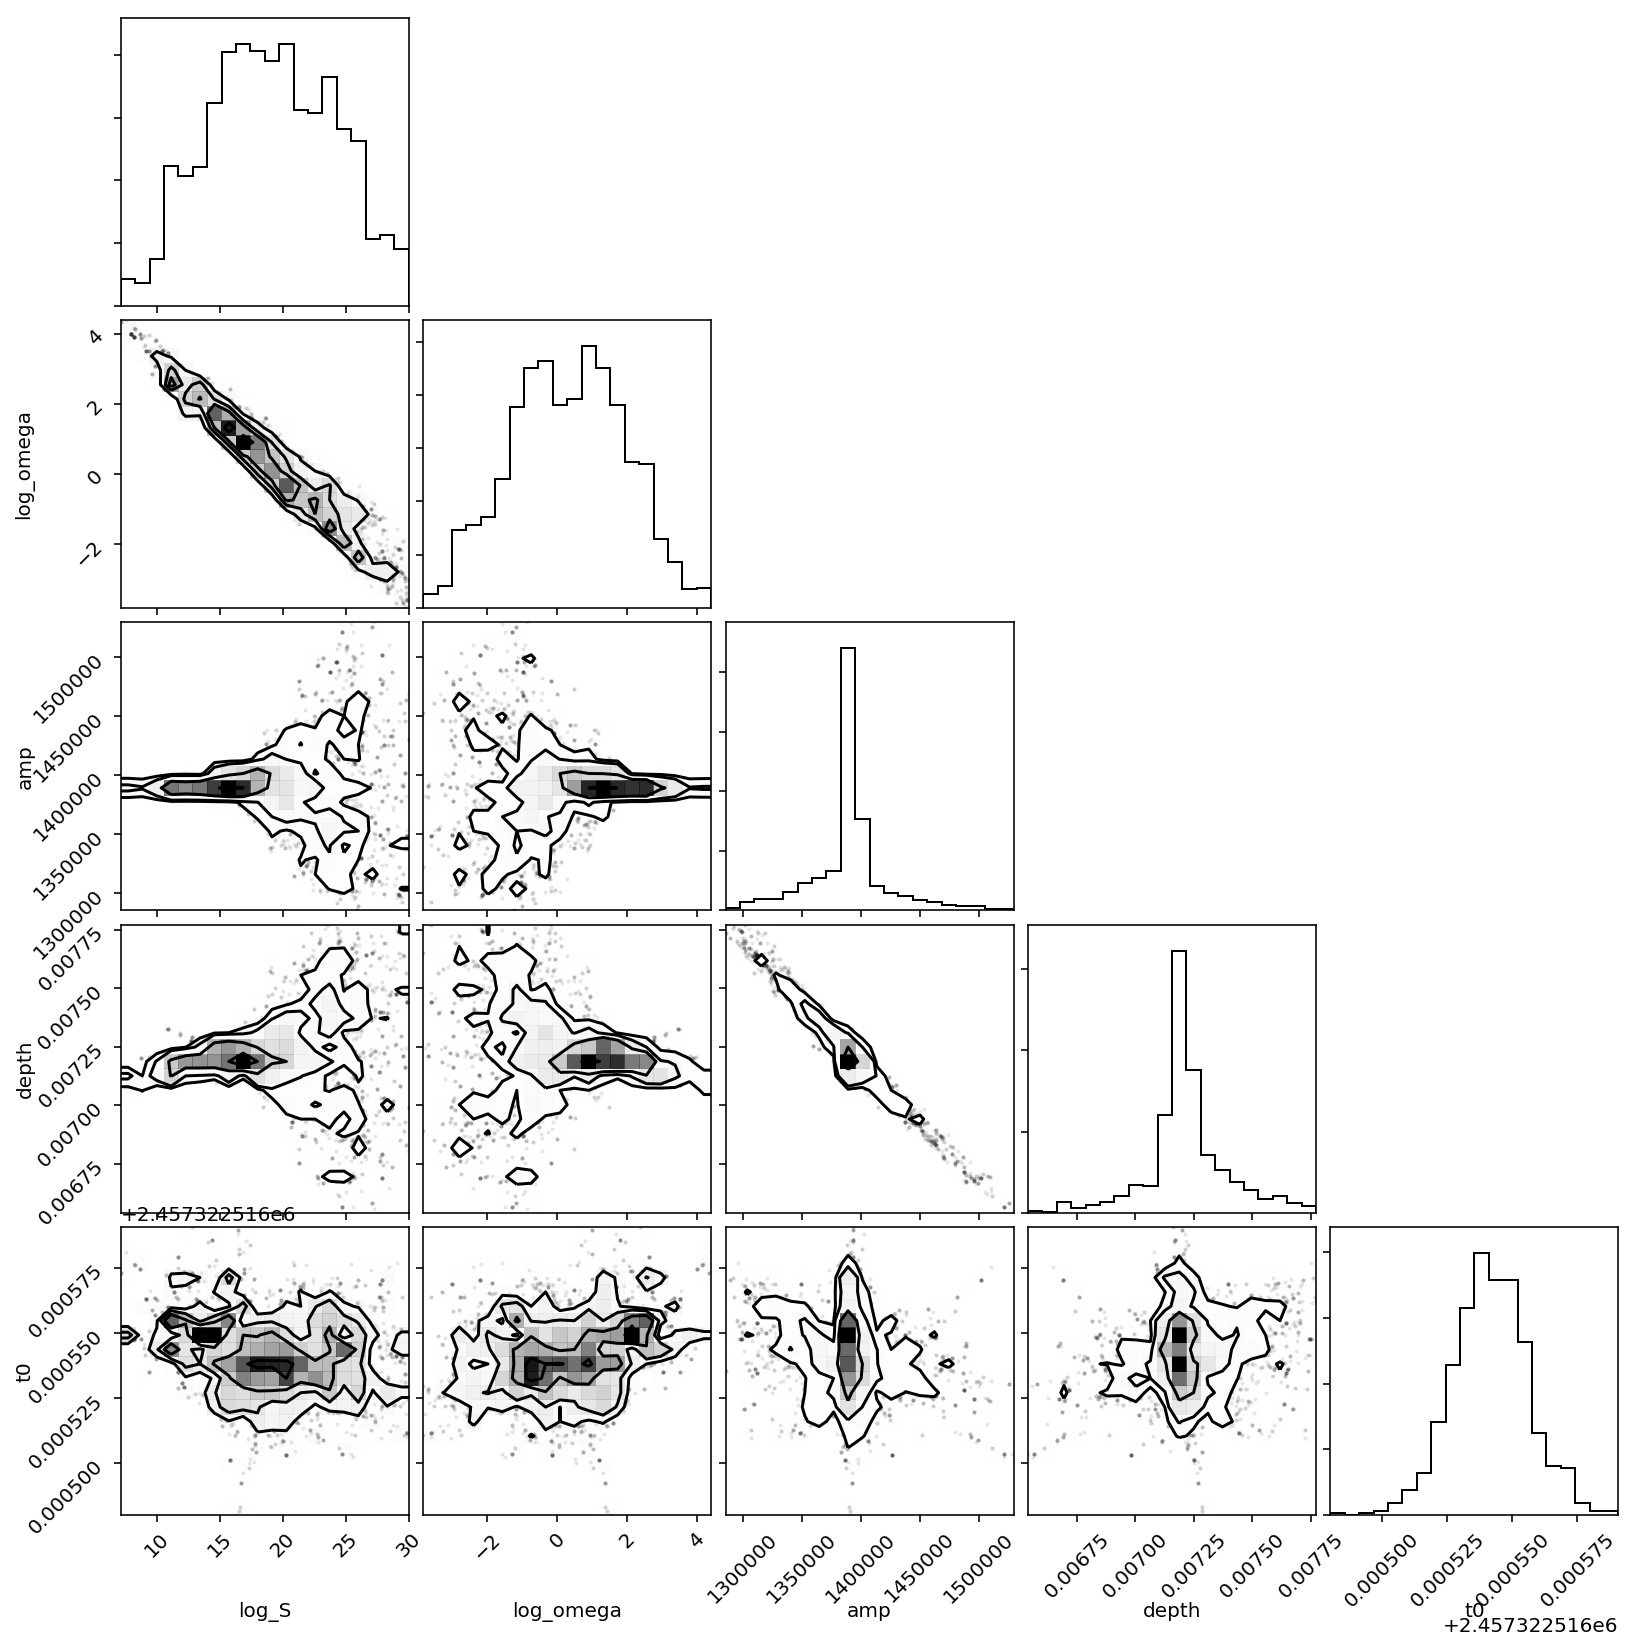

BlockingIOError: [Errno 35] Resource temporarily unavailable

In [18]:
import emcee 
from celerite.solver import LinAlgError

run_name = 'trappist1_transmission'

bin_results = []
bin_results_errs = []

with ObservationArchive(run_name, 'r') as obs:
    planet = 'b'
    for obs_planet in getattr(obs, planet):
        results = []
        errs = []
        fig, ax = plt.subplots(1, n_bins, figsize=(14, 4))
        for i in range(n_bins):
            mask = mask_simultaneous_transits(obs_planet.times, planet)
            obs_time = obs_planet.times[mask]
            obs_flux = np.sum(obs_planet.spectra[mask, i*bin_width:(i+1)*bin_width], axis=1)
            obs_err = np.sqrt(obs_flux)

            params = trappist1(planet)

            ## Begin celerite model
            initp_dict = dict(amp=np.median(obs_flux), depth=original_params.rp**2,
                              t0=original_params.t0)

            parameter_bounds = dict(amp=[0.9*np.min(obs_flux), 1.3*np.max(obs_flux)],
                                    depth=[0.9 * original_params.rp**2,
                                           1.1 * original_params.rp**2],
                                    t0=[original_params.t0 - 0.05,
                                        original_params.t0 + 0.05])

            mean_model = MeanModel(bounds=parameter_bounds, **initp_dict)

            x = obs_time
            y = obs_flux
            yerr = obs_err

            Q = 1.0 / np.sqrt(2.0)
            log_w0 = 5 #3.0
            log_S0 = 10

            log_cadence_min = None # np.log(2*np.pi/(2./24))
            log_cadence_max = np.log(2*np.pi/(0.25/24))

            bounds = dict(log_S0=(-15, 30), log_Q=(-15, 15),
                          log_omega0=(log_cadence_min, log_cadence_max))

            kernel = terms.SHOTerm(log_S0=log_S0, log_Q=np.log(Q),
                                   log_omega0=log_w0, bounds=bounds)

            kernel.freeze_parameter("log_Q")  # We don't want to fit for "Q" in this term

            gp = celerite.GP(kernel, mean=mean_model, fit_mean=True)
            gp.compute(x, yerr)
#             print("Initial log-likelihood: {0}".format(gp.log_likelihood(y)))

            # Define a cost function
            def neg_log_like(params, y, gp):
                gp.set_parameter_vector(params)
                return -gp.log_likelihood(y)

            def grad_neg_log_like(params, y, gp):
                gp.set_parameter_vector(params)
                return -gp.grad_log_likelihood(y)[1]

            # Fit for the maximum likelihood parameters
            initial_params = gp.get_parameter_vector()
            bounds = gp.get_parameter_bounds()
            soln = minimize(neg_log_like, initial_params, #jac=grad_neg_log_like,
                            method="L-BFGS-B", bounds=bounds, args=(y, gp))
            gp.set_parameter_vector(soln.x)
            
#             mu, var = gp.predict(obs_flux, obs_time, return_var=True)
            ax[i].plot(obs_time, obs_flux, '.')

#             ax[i].plot(obs_time, mu, ls='--')
            
            
#             print("Final log-likelihood: {0}".format(-soln.fun))
            
#             print(soln.x)
#             result = soln.x
            #results.append(result)
            
            def log_probability(params):
                gp.set_parameter_vector(params)
                lp = gp.log_prior()
                if not np.isfinite(lp):
                    return -np.inf
                return gp.log_likelihood(y) + lp

#             initial = np.array(soln.x)
            ndim, nwalkers = len(initial_params), len(initial_params) * 2

            # pool = MPIPool()
            # if not pool.is_master():
            #     pool.wait()
            #     sys.exit(0)

            try: 
                sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability,
                                                threads=8)

    #             print("Running burn-in...")
                p0 = soln.x + 1e-4 * np.random.randn(nwalkers, ndim)
                p0, lp, _ = sampler.run_mcmc(p0, 1000)

    #             print("Running production...")
                sampler.reset()
                sampler.run_mcmc(p0, 1000)

                results.append(np.median(sampler.flatchain, axis=0))
                errs.append(np.std(sampler.flatchain, axis=0))

                skip = 10
                mu, var = gp.predict(obs_flux, obs_time[::skip], return_var=True)
                std = np.sqrt(var)

                ax[i].plot(obs_time[::skip], mu, '.')
                
                
                from corner import corner 
                plt.figure()
                corner(sampler.chain[:, 500:, :].reshape(-1, ndim), labels=['log_S', 'log_omega', 'amp', 'depth', 't0'])
                plt.show()
            except LinAlgError:  
                print('LinAlgError passing')
                results.append(np.nan * np.ones(ndim)) # np.array(bin_results[-1])
                errs.append(np.nan * np.ones(ndim)) # np.array(bin_results_errs[-1])
        bin_results.append(results)
        bin_results_errs.append(errs)
        fig.tight_layout()
        mid_transit_answer = obs_planet.attrs['t0']
        plt.show()

In [9]:
depths = np.array([j[3] for i in bin_results for j in i]).reshape(-1, n_bins)

depths_errs = np.array([j[3] for i in bin_results_errs for j in i]).reshape(-1, n_bins)


depths_errs

array([[  1.67576471e-04,   1.01767458e-04,   2.16305848e-04,
          1.63855534e-04,   1.31936670e-04],
       [  8.16814185e-05,   1.16359062e-04,   6.81905612e-05,
          6.42826366e-05,              nan],
       [  1.56755103e-04,              nan,              nan,
                     nan,              nan],
       [  8.20919575e-05,   5.02334195e-05,   8.36731638e-05,
          8.63098755e-05,              nan],
       [  9.68688642e-05,   4.90353012e-05,   9.07914832e-05,
          7.05519653e-05,   1.37936804e-04],
       [  7.63339821e-05,   5.91122502e-05,   7.48766429e-05,
          7.06370569e-05,   1.03487164e-04],
       [  8.09663246e-05,   9.89627633e-05,   7.46536077e-05,
          1.10077715e-04,   1.52162265e-04],
       [  9.02570939e-05,   6.54390672e-05,   7.81169459e-05,
          9.75667501e-05,   1.40541347e-04],
       [  8.95973489e-05,   7.88211366e-05,   8.91574419e-05,
          8.52538276e-05,   1.68461492e-04],
       [  7.45494759e-05,   3.5981558

In [18]:
soln.x

array([  9.99982622e+00,   4.99999817e+00,   6.26728175e+05,
         7.61184978e-03,   2.45732252e+06])

In [22]:
np.tile(bin_centers, 10)

array([ 0.95934828,  2.29941717,  3.42829475,  4.27133223,  4.9657523 ,
        0.95934828,  2.29941717,  3.42829475,  4.27133223,  4.9657523 ,
        0.95934828,  2.29941717,  3.42829475,  4.27133223,  4.9657523 ,
        0.95934828,  2.29941717,  3.42829475,  4.27133223,  4.9657523 ,
        0.95934828,  2.29941717,  3.42829475,  4.27133223,  4.9657523 ,
        0.95934828,  2.29941717,  3.42829475,  4.27133223,  4.9657523 ,
        0.95934828,  2.29941717,  3.42829475,  4.27133223,  4.9657523 ,
        0.95934828,  2.29941717,  3.42829475,  4.27133223,  4.9657523 ,
        0.95934828,  2.29941717,  3.42829475,  4.27133223,  4.9657523 ,
        0.95934828,  2.29941717,  3.42829475,  4.27133223,  4.9657523 ])

In [19]:
np.savetxt('ten_transits_b.txt', np.vstack([np.tile(bin_centers, 10), depths.ravel(), depths_errs.ravel()]).T)

<Container object of 3 artists>

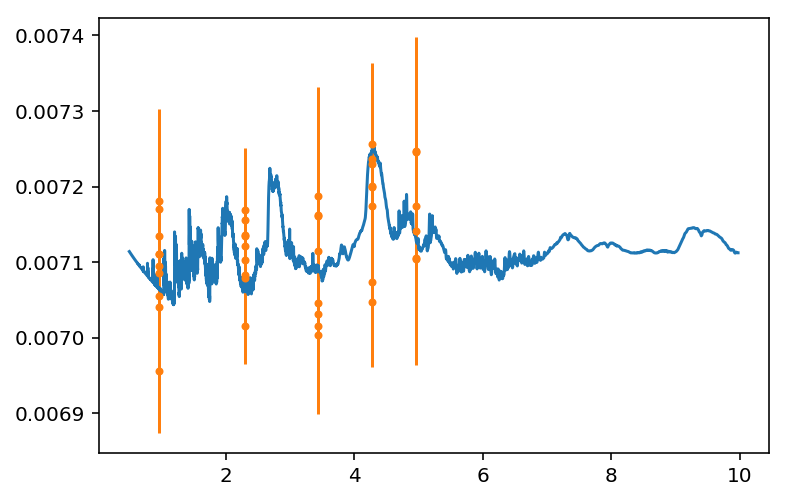

In [21]:
plt.plot(swl, sf * ld_factor, label='with LD')

plt.errorbar(*np.loadtxt('ten_transits_b.txt', unpack=True), fmt='.')


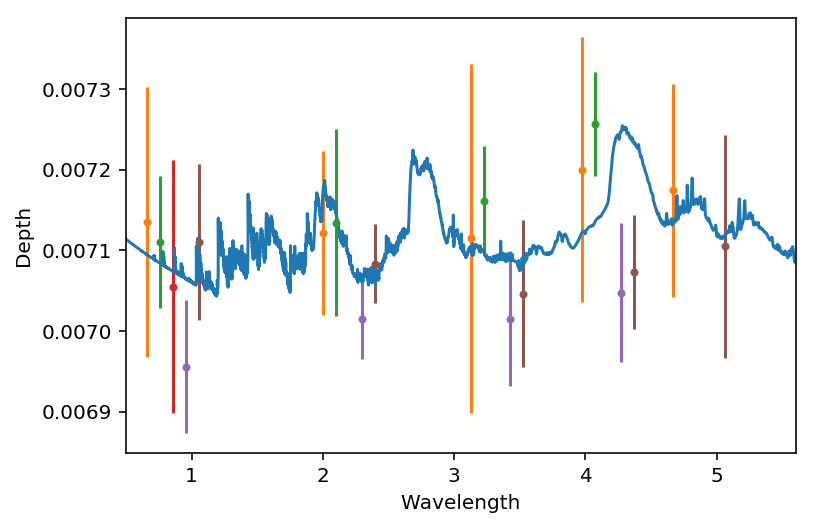

In [12]:
swl, sf = np.loadtxt('../libra/data/transmission/t1b_10bar_venus_clear.txt', unpack=True)

u = trappist1('b').u
ld_factor = 1 - u[0]/3 - u[1]/6

fig, ax = plt.subplots(1)#, 2, figsize=(12, 5))
ax.plot(swl, sf * ld_factor, label='with LD')

try: 
    for i in range(n_bins):
        ax.errorbar(bin_centers + (i - 3)*0.1, depths[i, :], depths_errs[i, :], fmt='.')
except IndexError:
    pass
ax.set(xlim=[0.5, 5.6], xlabel='Wavelength', ylabel='Depth')

model_interp = np.interp(bin_centers, swl, sf)

chi2 = np.sum((depths - model_interp)**2, axis=1)

# mean_fluxes = []
# with ObservationArchive(run_name, 'r') as obs:
#     planet = 'b'
#     for obs_planet in getattr(obs, planet):
#         mf = np.mean(obs_planet.flares)
#         mean_fluxes.append(mf)

#ax[1].plot(mean_fluxes, chi2, '.')
ax.set(xlabel='Wavelength', ylabel='Depth')
fig.savefig('transmission.png', bbox_inches='tight', dpi=200)
plt.show()

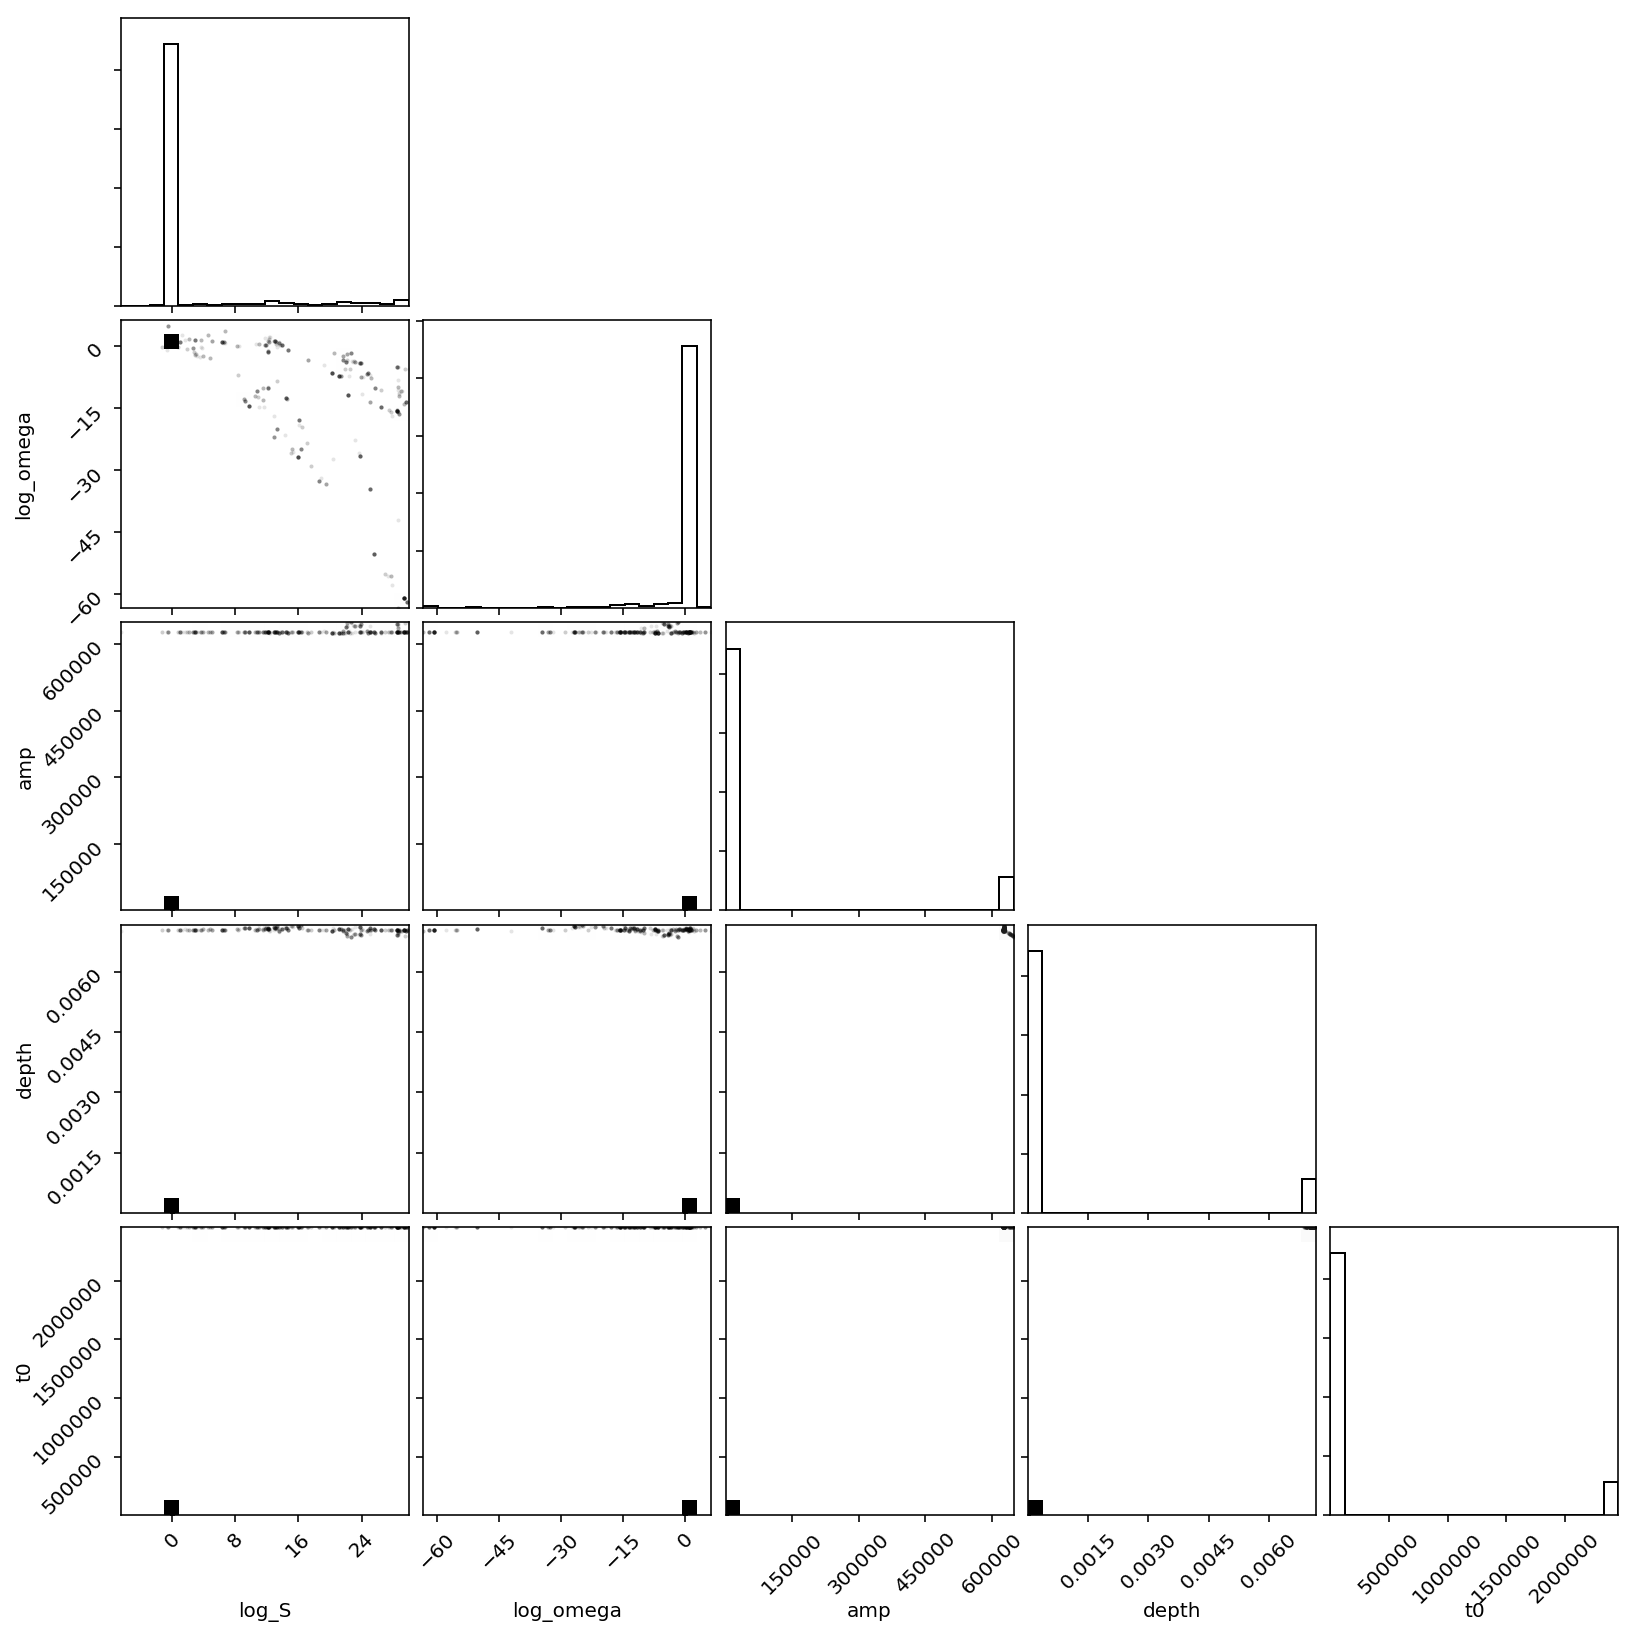

In [15]:
from corner import corner 

corner(sampler.chain[:, 1500:, :].reshape(-1, ndim), labels=['log_S', 'log_omega', 'amp', 'depth', 't0'])
plt.show()